# Learning a density-to-wave-function map

In this notebook, we will train a network to learn the mapping from the density to the wave function for a simple lattice system. In particular, we take a $6$-site spinless Hubbard model with periodic boundary conditions.

This is mapping is known to exist from the Hohenberg-Kohn theorem, which says that the external potential of a system can be determined (up to an overall constant) from the density, and therefore the wave function can be uniquely determined from the density too.

We generate training data points by applying random external potentials to the lattice model. This follows the approach described in the following paper:

*Javier Robledo Moreno, Giuseppe Carleo, Antoine Georges,
Physical Review Letters **125**, 076402 (2020)*

For this simple example we will train for $90$ epochs, with $128$ data points per batch, and $6400$ training data points in total:

In [1]:
nepochs = 90
batch_size = 128
ndata_train = 6400

We set the PyTorch random number generator seed, to help with reproducibility of results:

In [2]:
import torch
torch.manual_seed(7)

We will begin by creating the Hamiltonian object. We take a spinless Hubbard model system with $6$ sites, and $U/t=4$. In general, we have the option to allow all particle-number sectors to be considered simultaneously, by setting ```fixed_nparticles=False```. Here, we instead fix the system at half-filling (```nparticles=3```). ```max_V``` sepcifies the maximum absolute random potential value applied to each site. So here, the potential on each site can vary between $-0.5$ and $+0.5$.

In [3]:
from deep_hk import hamiltonian
system = hamiltonian.SpinlessHubbard(
    U=4.0,
    t=1.0,
    mu=4.0,
    max_V=0.5,
    nsites=6,
    fixed_nparticles=True,
    nparticles=3,
    seed=9)

We then need to construct the system object, which will create the Hamiltonian itself. The Hamiltonian is stored in a sparse SciPy CSR format. The ```construct()``` call will create the Hamiltonian without an external potential applied; external potentials are applied later as the training data is generated.

In [4]:
system.construct()

Now we will generate the training data. As noted above, we want to learn the wave function from the density. Therefore, we will be passing the density into the input of the network, and obtaining the wave function from its output. So we set ```input_type='density'``` and ```output_type='wave_function'```. It is also possible to save this data in CSV format and load it later using the path specified, which we do not do here.

In [5]:
from deep_hk import data
data_train = data.Data(
    system=system,
    ndata=ndata_train,
    input_type='density',
    output_type='wave_function',
    load=False,
    save=False,
    path='data_train.csv')

Next we focus on creating the network object itself. We will use a network of fully-connected layers, using the ```LinearNet``` class. The ```__init__``` function for this class takes a list of layers to be applied, which should be created using the ```create_linear_layers``` function:

In [6]:
from deep_hk import networks
layers_list = networks.create_linear_layers(
    ninput=data_train.ninput,
    num_hidden=[32, 64, 128],
    noutput=data_train.noutput,
    wf_output=True)

The ```num_hidden``` argument can be used to specify the number of hidden layers, and the number of units in each. Here we take $3$ hidden layers of size $32$, $64$ and $128$. Specifying ```wf_output=True``` tells the function that the output layer should be normalized to unity, as appropriate for a wave function object.

We can then use this list to create the network object itself, using a ReLU activation function in this case:

In [7]:
net = networks.LinearNet(layers_list, 'relu')

We next specify a loss function to be used in the optimization. Our goal is for the output to represent the exact wave function for the applied external potential (up to an overall sign factor). An appropriate loss function here is the infidelity, defined as:

$I(\psi_p, \psi_e) = 1 - |\langle \psi_p | \psi_e \rangle|$

where $|\psi_p\rangle$ is the predicted wave function, and $|\psi_e\rangle$ is the exact wave function. This loss function is defined in the train module:

In [8]:
from deep_hk import train
criterion = train.Infidelity()

Lastly, we use Adam as the optimizer:

In [9]:
import torch.optim as optim
optimizer = optim.Adam(
  net.parameters(),
  lr=0.001)

And we can finally train the network:

In [10]:
train.train(
    net=net,
    data_train=data_train,
    data_validation=None,
    criterion=criterion,
    optimizer=optimizer,
    nepochs=nepochs,
    batch_size=batch_size,
    save_net=False)

# 1. Epoch  2. Train. Loss
         0      0.18359140
         1      0.00343061
         2      0.00114083
         3      0.00095585
         4      0.00089445
         5      0.00086765
         6      0.00085289
         7      0.00084273
         8      0.00083481
         9      0.00082817
        10      0.00082213
        11      0.00081641
        12      0.00081072
        13      0.00080503
        14      0.00079911
        15      0.00079283
        16      0.00078614
        17      0.00077876
        18      0.00077060
        19      0.00076154
        20      0.00075149
        21      0.00074030
        22      0.00072712
        23      0.00071078
        24      0.00069249
        25      0.00067262
        26      0.00064983
        27      0.00062478
        28      0.00060008
        29      0.00057360
        30      0.00054945
        31      0.00052948
        32      0.00051160
        33      0.00049388
        34      0.00047724
        35      0.00046024
 

The final loss value is around $5\times 10^{-5}$, indicating an overlap of around $0.99995$ between the predicted wave functions and exact wave functions on average.

We can then generate some test data to assess the accuracy of the model in more detail:

In [11]:
ndata_test = 6400
data_test = data.Data(
    system=system,
    ndata=ndata_test,
    input_type='density',
    output_type='wave_function',
    load=False,
    save=False,
    path='data_test.csv')

We choose to look at the test data point with index $1$ (```data_label=1```). We can plot the random potential generated in this case:

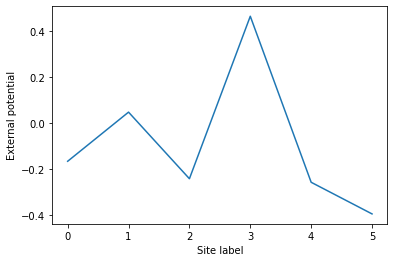

In [12]:
import matplotlib.pyplot as plt
data_label = 1
nsites = 6
site_labels = range(nsites)
plt.plot(site_labels, data_test.potentials[data_label])
plt.xlabel('Site label')
plt.ylabel('External potential')
plt.show()

Passing the test densities through the network to obtain the predicted wave function components:

In [13]:
outputs = net(data_test.inputs)
exact = abs(data_test.labels[data_label].detach())
predicted = abs(outputs[data_label].detach())

We can then plot the predicted wave function components against the exact components for the chosen data point, and see good agreement.

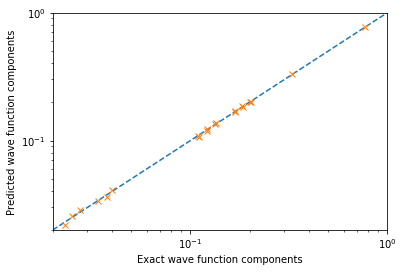

In [14]:
plt.xscale('log')
plt.yscale('log')
plt.xlim([2e-2,1])
plt.ylim([2e-2,1])
plt.plot([2e-2,1], [2e-2,1], linestyle='--')
plt.plot(exact, predicted, linestyle='None', marker='x')
plt.xlabel('Exact wave function components')
plt.ylabel('Predicted wave function components')
plt.show()

Lastly, we can look at the distribution of the loss values for the test data. Applying the network to each data point individually:

In [15]:
losses = []
for i in range(ndata_test):
  loss_test = criterion(outputs[i:i+1,:], data_test.labels[i:i+1,:])
  losses.append(loss_test.detach())

We can then plot the distribution:

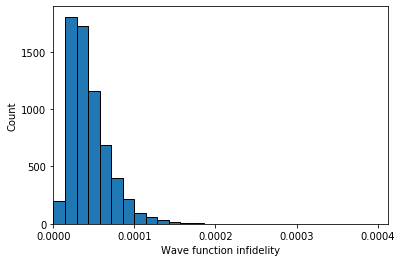

In [16]:
import numpy as np
bins = np.linspace(0, max(losses), 30)
plt.xlim([0, max(losses)])
plt.hist(losses, bins=bins, edgecolor='black')
plt.xlabel('Wave function infidelity')
plt.ylabel('Count')
plt.locator_params(nbins=5)
plt.show()

An example is given for a spinned Hubbard model on a larger lattice in the examples/hubbard directory.